# 4. Data Modeling

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_train = pd.read_csv('feature_train.csv')
X_test = pd.read_csv('feature_test.csv')
y_train = pd.read_csv('label_train.csv')
y_test = pd.read_csv('label_test.csv')

In [4]:
from imblearn.over_sampling import SMOTE

resampling = SMOTE(sampling_strategy = 'auto', random_state = 42) 
X_train, y_train  = resampling.fit_resample(X_train, y_train)

y_train.value_counts()

loan_status
0              144713
1              144713
2              144713
Name: count, dtype: int64

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

def eval_classification(model) :
    y_pred             = model.predict(X_test)
    y_pred_train       = model.predict(X_train)
    y_pred_proba       = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('Accuracy (Train Set)    : %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test Set)     : %.2f' % accuracy_score(y_test, y_pred))
    
    print('Precision (Train Set)   : %.2f' % precision_score(y_train, y_pred_train, average='macro'))
    print('Precision (Test Set)    : %.2f' % precision_score(y_test, y_pred, average='macro'))
    
    print('Recall (Train Set)      : %.2f' % recall_score(y_train, y_pred_train, average='macro'))
    print('Recall (Test Set)       : %.2f' % recall_score(y_test, y_pred, average='macro'))
    
    print('F1-Score (Train Set)    : %.2f' % f1_score(y_train, y_pred_train, average='macro'))
    print('F1-Score (Test Set)     : %.2f' % f1_score(y_test, y_pred, average='macro'))

    print('ROC-AUC (Train-Proba)   : %.2f' % roc_auc_score(y_train, y_pred_proba_train, multi_class='ovr', average='macro'))
    print('ROC-AUC (Test-Proba)    : %.2f' % roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro'))

def show_feature_importance(model) :
    feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind = 'barh', figsize = (10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score - Data Test')
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(model) :
    cm   = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = plt.cm.Blues)
    
    plt.title('Confusion Matrix - Data Test')
    plt.tight_layout()
    plt.show()

def show_best_hyperparameter(model) :
    print(model.best_estimator_.get_params())

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42, multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train, y_train)
eval_classification(lr)

Accuracy (Train Set)    : 0.41
Accuracy (Test Set)     : 0.42
Precision (Train Set)   : 0.41
Precision (Test Set)    : 0.40
Recall (Train Set)      : 0.41
Recall (Test Set)       : 0.41
F1-Score (Train Set)    : 0.41
F1-Score (Test Set)     : 0.38
ROC-AUC (Train-Proba)   : 0.60
ROC-AUC (Test-Proba)    : 0.60


In [7]:
from sklearn.model_selection import RandomizedSearchCV

hyperparameters = {#'C' : [float(x) for x in np.linspace(0.0001, 0.5, 100)],
                   'penalty' : [None, 'l2'],
                   'max_iter' : [50, 100, 200],
                   'solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
                   'multi_class' : ['multinomial', 'auto']}

lr = LogisticRegression(random_state = 42)
lr_tuned = RandomizedSearchCV(lr, hyperparameters, cv = 5, random_state = 42, scoring = 'roc_auc')
lr_tuned.fit(X_train, y_train)
eval_classification(lr_tuned)

Accuracy (Train Set)    : 0.68
Accuracy (Test Set)     : 0.73
Precision (Train Set)   : 0.68
Precision (Test Set)    : 0.65
Recall (Train Set)      : 0.68
Recall (Test Set)       : 0.65
F1-Score (Train Set)    : 0.68
F1-Score (Test Set)     : 0.64
ROC-AUC (Train-Proba)   : 0.85
ROC-AUC (Test-Proba)    : 0.84


In [8]:
show_best_hyperparameter(lr_tuned)

{'C': 0.08594141414141414, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


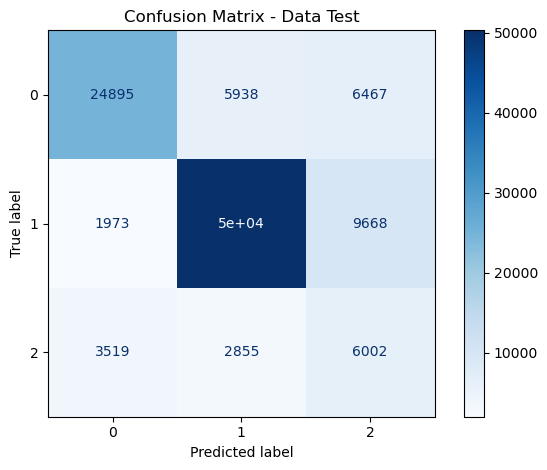

In [9]:
show_confusion_matrix(lr_tuned)

In [ ]:
explainer = shap.Explainer(lr_tuned.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0], X_test.iloc[0, :])

In [10]:
import xgboost as xgb

xg = xgb.XGBClassifier(random_state = 42)
xg.fit(X_train, y_train)
eval_classification(xg)

Accuracy (Train Set)    : 0.99
Accuracy (Test Set)     : 0.98
Precision (Train Set)   : 0.99
Precision (Test Set)    : 0.98
Recall (Train Set)      : 0.99
Recall (Test Set)       : 0.95
F1-Score (Train Set)    : 0.99
F1-Score (Test Set)     : 0.96
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.99


In [16]:
hyperparameters = { 'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]}

xg_tuned = xgb.XGBClassifier(random_state = 42)
xg_tuned = RandomizedSearchCV(xg_tuned, hyperparameters, cv = 5, random_state = 42, scoring = 'roc_auc')
xg_tuned.fit(X_train, y_train)

eval_classification(xg_tuned)

Accuracy (Train Set)    : 0.99
Accuracy (Test Set)     : 0.98
Precision (Train Set)   : 0.99
Precision (Test Set)    : 0.98
Recall (Train Set)      : 0.99
Recall (Test Set)       : 0.94
F1-Score (Train Set)    : 0.99
F1-Score (Test Set)     : 0.96
ROC-AUC (Train-Proba)   : 1.00
ROC-AUC (Test-Proba)    : 0.99


In [25]:
show_best_hyperparameter(xg_tuned)

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.30000000000000004, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.5, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': None, 'min_child_weight': 18, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'approx', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.8, 'eta': 0.33333333333333337, 'alpha': 0.8}


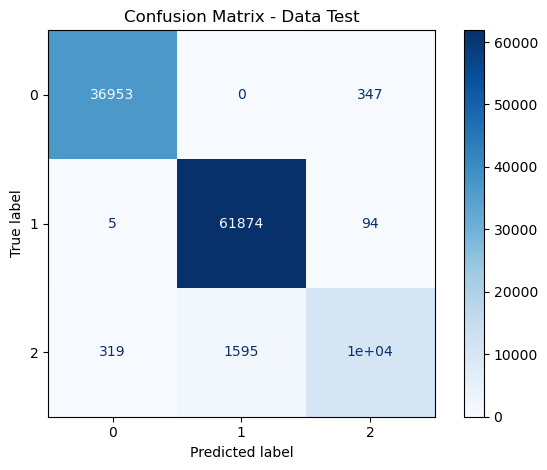

In [27]:
show_confusion_matrix(xg_tuned)

In [ ]:
explainer = shap.Explainer(xg_tuned.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

PermutationExplainer explainer:  35%|███▍      | 38853/111649 [1:36:46<4:18:11,  4.70it/s]

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0], X_test.iloc[0, :])